# ***Feature Engineering***

# QA
----
## **1. 两个类别型变量构造笛卡尔特征组合为什么能提升模型表现？**
 笛卡尔乘积是指在数学中，两个集合X和Y的笛卡尓积（ Cartesian product ），又称直积，表示为 X×Y ，第一个对象是X的成员而第二个对象是 Y 的所有可能有序对的其中一个成员。假设集合 A={a, b} ，集合 B={0, 1, 2} ，则两个集合的笛卡尔积为 {(a, 0), (a, 1), (a, 2), (b, 0), (b, 1), (b, 2)}，然后用one hot 或其他embedding方式给新的特征编码。
 
通过将单独的特征求笛卡尔乘积的方式来组合2个或更多个特征，从而构造出组合特征。最终获得的预测能力将远远超过任一特征单独的预测能力。例如，如果狗狗在下午5点主人下班回来时（快乐地）叫喊，可能表示对主人满意度的正面预测结果。如果狗狗在凌晨3点主人熟睡时（也许痛苦地）哀叫，可能表示对主人满意度的强烈负面预测结果。

日常工作场景中的特征往往都是以用户和其对应的属性作为出发点，然后和物品对应的属性特征或者上下文特征进行交叉组合。在实际的场景中，往往会结合数据分析去挖掘潜在的价值特征组合。这时候便会借助数据分析、数据挖掘、分析者的敏感直觉和对业务的深入理解去进行挖掘。例如，不同人群对于APP推送消息的处理风格和处理时间很不一样，有的人会直接划掉，有的人则会在某个时间段进行消息查看，这时候便可以考虑对用户Push消息提供个性化时间分发，从而提高用户的打开率。




# ***Titanic***
## test survival on the Titanic
----
融合之前的三个模型，并且根据需要重新做特征工程，构建一个通用的df
重新填补缺失的年龄值
重新处理分类变量（对lgbm和rf、logistic分别处理）
提取并观察舱室特征
提取姓特征（出现频率，类似Companion）
归类头衔

先单独用lgbm，最后再尝试融合




In [6]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import re
from category_encoders import *




----
## 1. 处理数据提取新特征
填充缺失值

提取新数据



In [7]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

D:\programs\envs\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Embarked', ylabel='count'>

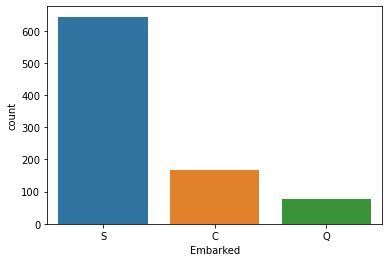

In [10]:
sns.countplot(train.Embarked)

In [11]:
for i in range(len(train.Embarked)):
    if not train.Embarked.iloc[i]==train.Embarked.iloc[i]:
        train.Embarked.iloc[i]='S'
        

D:\programs\envs\python36\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [12]:
fare = test.Fare.values
avg_fare = np.nanmean(fare)
for i in range(len(test.Fare)):
    if not test.Fare.iloc[i]==test.Fare.iloc[i]:
        test.Fare.iloc[i]=avg_fare

<AxesSubplot:>

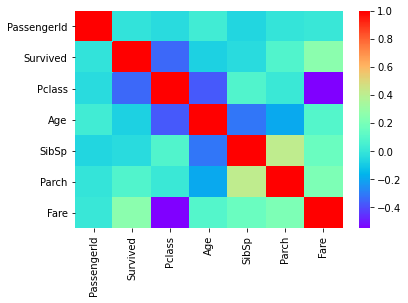

In [13]:
sns.heatmap(train.corr(), cmap='rainbow')

In [14]:
pattern = re.compile(r'\d.*')
def split_cabin(s):
    if s==s:
        s = s.split()[0]
        if len(s)>=2:
            cabin_section = s[0]
            cabin_num = pattern.search(s).group()
        else:
            cabin_section = s[0]
            cabin_num = np.nan
    else:
        cabin_section = np.nan
        cabin_num = np.nan
    return [cabin_section, cabin_num]
def get_cabin_feature(df):
    cabin = np.array([split_cabin(s) for s in df.Cabin])
    cabin_section = cabin[:,0]
    cabin_num = cabin[:,1]
    df['Cabin_section'] = cabin_section
    df['Cabin_num'] = cabin_num
    
    
    
    
    

In [15]:
pd.Series([1,2,3]).replace({1:'a'})

0    a
1    2
2    3
dtype: object

In [16]:

get_cabin_feature(train)
train.Cabin_num = train.Cabin_num.replace({'nan':np.nan})
train.Cabin_num = pd.to_numeric(train.Cabin_num)
get_cabin_feature(test)
test.Cabin_num = test.Cabin_num.replace({'nan':np.nan})
test.Cabin_num = pd.to_numeric(test.Cabin_num)

In [17]:
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

<AxesSubplot:xlabel='Cabin_section', ylabel='Survived'>

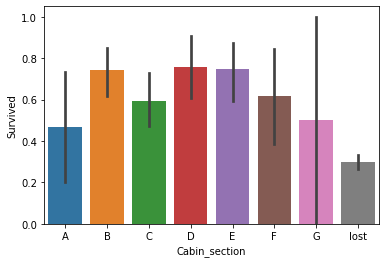

In [18]:
train.Cabin_section = train.Cabin_section.replace({'nan': 'lost'})
test.Cabin_section = test.Cabin_section.replace({'nan': 'lost'})
sns.barplot(x=train.Cabin_section, y=train.Survived, order=['A','B','C','D','E','F','G','lost'])

<AxesSubplot:xlabel='Survived', ylabel='Cabin_num'>

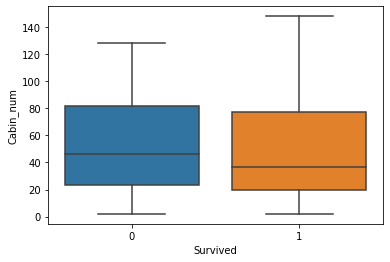

In [19]:
sns.boxplot(y=train.Cabin_num, x=train.Survived)

----
以上结果说明数值缺失者生还率较低，而舱室号和生还率关系不是很大，构建尝试信息是否缺失的特征，再对年龄做同样的工作,并且观察两种缺失间的关系

In [20]:

train['Cabin_lost'] = [1 if x=='lost' else 0 for x in train.Cabin_section ]
train['Age_lost'] = [0 if x==x else 1 for x in train.Age]
test['Cabin_lost'] = [1 if x=='lost' else 0 for x in test.Cabin_section ]
test['Age_lost'] = [0 if x==x else 1 for x in test.Age]

<AxesSubplot:xlabel='Cabin_lost', ylabel='Survived'>

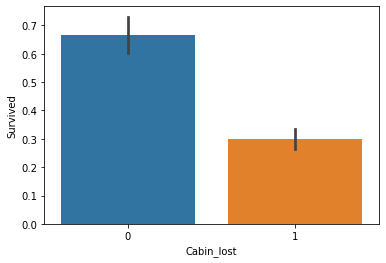

In [21]:
sns.barplot(x=train.Cabin_lost, y=train.Survived)

<AxesSubplot:xlabel='Age_lost', ylabel='Survived'>

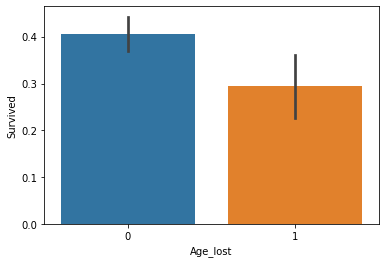

In [22]:
sns.barplot(x=train.Age_lost, y=train.Survived)

<AxesSubplot:>

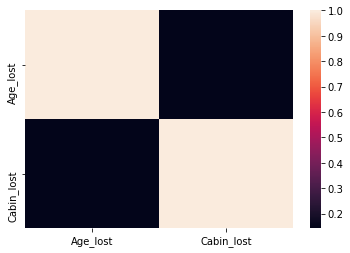

In [23]:
temp = pd.DataFrame({'Age_lost':train.Age_lost, 'Cabin_lost':train.Cabin_lost})
sns.heatmap(temp.corr())

----
两个特征相关性不高，可能有用。接下来填补age缺失值，缺失情况已经留作特征。cabin已经抛弃，cabin_num可能也没有用，后续选择特征再看。

先处理分类变量，然后用随机森林回归填补年龄缺失值。先处理头衔

In [24]:
name_train = train.Name.values
name_test = test.Name.values
title_dict = {"Capt": "Officer", "Col": "Officer", "Major": "Officer", 
                  "Jonkheer": "Sir", "Don": "Sir", "Sir": "Sir", "Dr": "Dr", 
                  "Rev": "Rev", "theCountess": "Lady", "Dona": "Lady", 
                  "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs", "Mr": "Mr", 
                  "Mrs": "Mrs", "Miss": "Miss", "Master": "Master",
                  "Lady": "Lady"}
titles = set(title_dict.keys())
def get_title(name):
    name=name.replace('.', '').split()
    join=set(name) & titles
    if  join:
        return title_dict[list(join)[0]]
    else:
        return 'None'
title_train = [get_title(name) for name in name_train]
title_test = [get_title(name) for name in name_test]
train['Title'] = title_train
test['Title']= title_test

In [25]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_section,Cabin_num,Cabin_lost,Age_lost,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,lost,NaN,1,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,85.0,0,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,lost,NaN,1,0,Miss


----
下面用目标编码处理一些重要的分类变量

In [26]:

cat_cols = ['Pclass', 'Embarked', 'Cabin_section', 'Title']
label = "Survived"
drop_cols = ['Name', 'Ticket', 'Cabin_num']
# X_train = train[cat_cols]
# X_test = test[cat_cols]
# y_train = train[label]

# enc = TargetEncoder()
# new_X_train = enc.transform_train(X_train, y_train)
# new_X_test = enc.transform_test(X_test)

def df_processor(df, target_col, drop_col, categorical_feature):
    droping = drop_col.copy()
    label = df[target_col]
    droping.append(target_col)
    features = df.drop(droping,axis=1)
    lgb_df =  lgb.Dataset(features, label=label, free_raw_data=False,
                        feature_name=list(features.columns), 
                        categorical_feature=categorical_feature)
    new_df = pd.concat([features, label], axis=1)
    return new_df, lgb_df, features, label


xxxx_train, lgb_train, train_X, train_y = df_processor(train, label, drop_cols, cat_cols)

test = test.drop(drop_cols, axis=1)




In [27]:
enc = TargetEncoder(cols=cat_cols).fit(train_X, train_y)
train_X = enc.transform(train_X)
train_y = train.Survived
test = enc.transform(test)



D:\programs\envs\python36\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [28]:
train_X.Sex = train_X.Sex.map({'male':0, 'female':1})
test.Sex = test.Sex.map({'male':0, 'female':1})

In [29]:
train_X

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_section,Cabin_lost,Age_lost,Title
0,1,0.242363,0,22.0,1,0,7.2500,0.339009,0.299854,1,0,0.156673
1,2,0.629630,1,38.0,1,0,71.2833,0.553571,0.593220,0,0,0.795276
2,3,0.242363,1,26.0,0,0,7.9250,0.339009,0.299854,1,0,0.701087
3,4,0.629630,1,35.0,1,0,53.1000,0.339009,0.593220,0,0,0.795276
4,5,0.242363,0,35.0,0,0,8.0500,0.339009,0.299854,1,0,0.156673
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.472826,0,27.0,0,0,13.0000,0.339009,0.299854,1,0,0.002569
887,888,0.629630,1,19.0,0,0,30.0000,0.339009,0.744681,0,0,0.701087
888,889,0.242363,1,NaN,1,2,23.4500,0.339009,0.299854,1,1,0.701087
889,890,0.629630,0,26.0,0,0,30.0000,0.553571,0.593220,0,0,0.156673


In [30]:
pca=PCA(n_components=1)
ncol=pca.fit_transform(train_X[['SibSp','Parch']])
train_X["Companion"]=ncol
pca=PCA(n_components=1)
ncol=pca.fit_transform(test[['SibSp','Parch']])
test["Companion"]=ncol

----

下面填补年龄缺失值

In [31]:
age_df = pd.concat([train_X,test], axis=0)
age_df, lgb_age_df, age_X, age_y = df_processor(age_df, 'Age', [], [])

In [32]:
age_df.isnull().sum()

PassengerId        0
Pclass             0
Sex                0
SibSp              0
Parch              0
Fare               0
Embarked           0
Cabin_section      0
Cabin_lost         0
Age_lost           0
Title              0
Companion          0
Age              263
dtype: int64

In [33]:
def df_nan_split(df, nan_col):
    normal_loc_list=[]
    nan_loc_list=[]
    for i in range(len(df[nan_col])):
        item = df[nan_col].iloc[i]
        if item==item:
            normal_loc_list.append(i)
        else:
            nan_loc_list.append(i)
    return df.iloc[normal_loc_list], df.iloc[nan_loc_list]

age_train, age_pred = df_nan_split(age_df, 'Age')


In [34]:
age_train.head(3)

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Cabin_section,Cabin_lost,Age_lost,Title,Companion,Age
0,1,0.242363,0,1,0,7.2500,0.339009,0.299854,1,0,0.156673,0.259128,22.0
1,2,0.629630,1,1,0,71.2833,0.553571,0.593220,0,0,0.795276,0.259128,38.0
2,3,0.242363,1,0,0,7.9250,0.339009,0.299854,1,0,0.701087,-0.637826,26.0


In [35]:
_,_, age_X, age_y = df_processor(age_train, 'Age', [], [])

age_X

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Cabin_section,Cabin_lost,Age_lost,Title,Companion
0,1,0.242363,0,1,0,7.2500,0.339009,0.299854,1,0,0.156673,0.259128
1,2,0.629630,1,1,0,71.2833,0.553571,0.593220,0,0,0.795276,0.259128
2,3,0.242363,1,0,0,7.9250,0.339009,0.299854,1,0,0.701087,-0.637826
3,4,0.629630,1,1,0,53.1000,0.339009,0.593220,0,0,0.795276,0.259128
4,5,0.242363,0,0,0,8.0500,0.339009,0.299854,1,0,0.156673,-0.637826
...,...,...,...,...,...,...,...,...,...,...,...,...
409,1301,0.242363,1,1,1,13.7750,0.339009,0.299854,1,0,0.701087,0.817606
411,1303,0.629630,1,1,0,90.0000,0.389610,0.593220,0,0,0.795276,0.016856
412,1304,0.242363,1,0,0,7.7750,0.339009,0.299854,1,0,0.701087,-0.582143
414,1306,0.629630,1,0,0,108.9000,0.553571,0.593220,0,0,0.383838,-0.582143


In [36]:
estimator = RandomForestRegressor()
params0 = {'n_estimators': range(1, 200 ,10)}
grid_search0 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params0, 
                        scoring='r2')
grid_search0.fit(age_X.drop('PassengerId', axis=1),age_y)
grid_search0.best_score_, grid_search0.best_params_

(0.37889206810006343, {'n_estimators': 171})

In [37]:
rf_clf0 = RandomForestRegressor(n_estimators=131, oob_score=True)
rf_clf0.fit(age_X.drop('PassengerId', axis=1),age_y).oob_score_

0.37727743840695804

In [38]:
estimator = RandomForestRegressor(n_estimators=131)
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params1 = {'max_depth':range(3,20,2),
        'min_samples_split':range(1,20,2),
        'min_samples_leaf':range(1,3)}

grid_search1 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params1, 
                        scoring='r2')
grid_search1.fit(age_X.drop('PassengerId', axis=1),age_y)
grid_search1.best_score_, grid_search1.best_params_

D:\programs\envs\python36\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.33976702 0.33474661 0.33517874 0.33827879 0.34150349
 0.33940345 0.33555925 0.33230439 0.33465068        nan 0.33355329
 0.33584052 0.33562111 0.33372869 0.33657063 0.33100463 0.33387605
 0.33163384 0.33184157        nan 0.43269844 0.43052618 0.43111954
 0.43194495 0.42922043 0.4256311  0.42242253 0.42063653 0.42134155
        nan 0.42918487 0.42979458 0.43148424 0.42905025 0.43000435
 0.42400332 0.4232443  0.41992851 0.41992443        nan 0.42698143
 0.43023094 0.43402122 0.43236263 0.43124069 0.42818715 0.42863506
 0.42532801 0.42454622        nan 0.42557948 0.4306512  0.42774544
 0.43113742 0.42716207 0.43070769 0.42706441 0.42416129 0.4257077
        nan 0.41581526 0.42061852 0.42356312 0.42936735 0.42909273
 0.42584472 0.4213837  0.42369691 0.42424752        nan 0.41767557
 0.41590936 0.42059736 0.42704218 0.42192164 0.421537

(0.43402121551863404,
 {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 7})

In [39]:
rf_clf1 = RandomForestRegressor(n_estimators=131, oob_score=True,max_depth=7, min_samples_leaf=1, min_samples_split=7)
rf_clf1.fit(age_X.drop('PassengerId', axis=1),age_y).oob_score_

0.4474102782914128

In [40]:
fill_age = rf_clf1.predict(age_pred.drop(['PassengerId','Age'], axis=1))
age_pred['Age'] = fill_age

D:\programs\envs\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
age_pred

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Cabin_section,Cabin_lost,Age_lost,Title,Companion,Age
5,6,0.242363,0,0,0,8.4583,0.389610,0.299854,1,1,0.156673,-0.637826,28.512920
17,18,0.472826,0,0,0,13.0000,0.339009,0.299854,1,1,0.156673,-0.637826,33.247595
19,20,0.242363,1,0,0,7.2250,0.553571,0.299854,1,1,0.795276,-0.637826,39.226881
26,27,0.242363,0,0,0,7.2250,0.553571,0.299854,1,1,0.156673,-0.637826,29.896647
28,29,0.242363,1,0,0,7.8792,0.389610,0.299854,1,1,0.701087,-0.637826,23.497301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1300,0.242363,1,0,0,7.7208,0.389610,0.299854,1,1,0.701087,-0.582143,22.472262
410,1302,0.242363,1,0,0,7.7500,0.389610,0.299854,1,1,0.701087,-0.582143,23.754776
413,1305,0.242363,0,0,0,8.0500,0.339009,0.299854,1,1,0.156673,-0.582143,26.687695
416,1308,0.242363,0,0,0,8.0500,0.339009,0.299854,1,1,0.156673,-0.582143,26.687695


In [42]:
age_df.head(8)

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Cabin_section,Cabin_lost,Age_lost,Title,Companion,Age
0,1,0.242363,0,1,0,7.2500,0.339009,0.299854,1,0,0.156673,0.259128,22.0
1,2,0.629630,1,1,0,71.2833,0.553571,0.593220,0,0,0.795276,0.259128,38.0
2,3,0.242363,1,0,0,7.9250,0.339009,0.299854,1,0,0.701087,-0.637826,26.0
3,4,0.629630,1,1,0,53.1000,0.339009,0.593220,0,0,0.795276,0.259128,35.0
4,5,0.242363,0,0,0,8.0500,0.339009,0.299854,1,0,0.156673,-0.637826,35.0
5,6,0.242363,0,0,0,8.4583,0.389610,0.299854,1,1,0.156673,-0.637826,NaN
6,7,0.629630,0,0,0,51.8625,0.339009,0.750000,0,0,0.156673,-0.637826,54.0
7,8,0.242363,0,3,1,21.0750,0.339009,0.299854,1,0,0.575000,2.495160,2.0


In [43]:
age_df.set_index('PassengerId', inplace=True)
age_pred.set_index('PassengerId', inplace=True)



In [44]:
for i in age_df.index:
    if age_df.Age.loc[i]!=age_df.Age.loc[i]:
        age_df.Age.loc[i] = age_pred.Age.loc[i]

D:\programs\envs\python36\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [45]:
age_df.isnull().sum()

Pclass           0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
Cabin_section    0
Cabin_lost       0
Age_lost         0
Title            0
Companion        0
Age              0
dtype: int64

In [46]:
train_X['Age'] = age_df.Age.loc[1:891].values
test['Age'] = age_df.Age.loc[892:].values


----
基础数据准备完毕，接下来引入lightgbm并选择特征

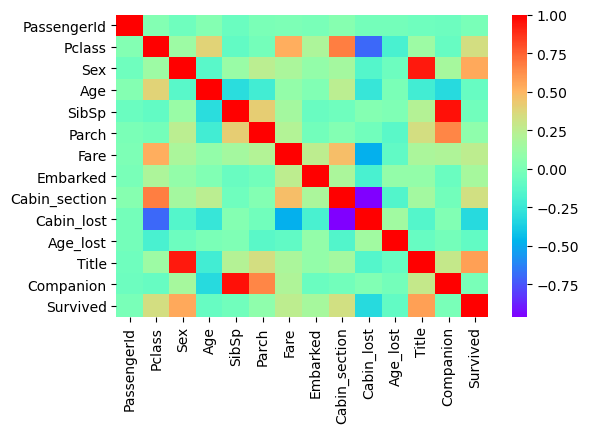

In [47]:

train = pd.concat([train_X, train_y], axis=1)
plt.figure(dpi=100)
sns.heatmap(train.corr(), cmap='rainbow')

train = train.drop('PassengerId', axis=1)
test = test.drop('PassengerId', axis=1)


In [48]:

# train_pick_cols=['Age','Fare','Companion','Sex','Cabin_lost','Survived']
# test_pick_cols=['Age','Fare','Companion','Sex','Cabin_lost']
# train=train[train_pick_cols]
# test=test[test_pick_cols]

In [46]:
train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_section,Cabin_lost,Age_lost,Title,Companion,Survived
0,0.242363,0,22.000000,1,0,7.2500,0.339009,0.299854,1,0,0.156673,0.259128,0
1,0.629630,1,38.000000,1,0,71.2833,0.553571,0.593220,0,0,0.795276,0.259128,1
2,0.242363,1,26.000000,0,0,7.9250,0.339009,0.299854,1,0,0.701087,-0.637826,1
3,0.629630,1,35.000000,1,0,53.1000,0.339009,0.593220,0,0,0.795276,0.259128,1
4,0.242363,0,35.000000,0,0,8.0500,0.339009,0.299854,1,0,0.156673,-0.637826,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.472826,0,27.000000,0,0,13.0000,0.339009,0.299854,1,0,0.002569,-0.637826,0
887,0.629630,1,19.000000,0,0,30.0000,0.339009,0.744681,0,0,0.701087,-0.637826,1
888,0.242363,1,6.461312,1,2,23.4500,0.339009,0.299854,1,1,0.701087,1.143377,0
889,0.629630,0,26.000000,0,0,30.0000,0.553571,0.593220,0,0,0.156673,-0.637826,1


In [47]:
def prepare_for_light_gbm(data,id_col,drop_cols,target_col):
    # Drop target column
    if target_col is not None:
        labels = data[target_col]
        drop_cols = drop_cols + [target_col]
    else:
        labels = []

    if id_col is not None:
        ids = data[id_col]
        drop_cols = drop_cols + [id_col]
    else:
        ids = []

    if drop_cols is not None:
        data = data.drop(drop_cols, axis=1)

    # Create LGB mats
    lgb_data = lgb.Dataset(data, label=labels, free_raw_data=False,
                                                  feature_name=list(data.columns))

    return lgb_data, labels, ids, data


In [48]:
train_split_df, valid_split_df = train_test_split(train, test_size=0.4)

(train_lgb_dataset, train_labels,
     train_ids, train_split_df) = prepare_for_light_gbm(
        train_split_df,drop_cols=[],id_col=None, target_col='Survived')

(valid_lgb_dataset, valid_labels,
     valid_ids, valid_split_df) = prepare_for_light_gbm(
        valid_split_df,drop_cols=[], id_col=None,target_col='Survived')

test_lgb_dataset, _, _, test_df = prepare_for_light_gbm(
        test,drop_cols=[],id_col=None, target_col=None)

    # Prepare data set using all the training data
(train_valid_lgb_dataset, train_valid_labels,
     _, train_valid_df) = prepare_for_light_gbm(
        train,drop_cols=[],id_col=None, target_col='Survived')

In [49]:
params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
              'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
              'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
              'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
              'min_split_gain': 0.5, 'min_child_weight': 1, 
              'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
              'metric': 'binary_error'}
    # Create parameters to search
grid_params = {'learning_rate': [0.01], 'n_estimators': [8, 16, 24, 32, 48],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

    # Create classifier to use. Note that parameters have to be input manually
    # not as a dict!
mod = lgb.LGBMClassifier(**params)

    # To view the default model params:
mod.get_params().keys()

    # Create the grid
grid = GridSearchCV(mod, param_grid=grid_params, cv=5, verbose=1, n_jobs=-1)
    # Run the grid
grid.fit(train_valid_df, train_valid_labels)

    # Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

    # Using parameters already set above, replace in the best from the grid search






Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.01, 'n_estimators': 48, 'num_leaves': 12, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 500, 'subsample': 0.75}
0.7980164459230432


Fitting model 0
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.219101	valid_1's binary_error: 0.204482
[100]	training's binary_error: 0.162921	valid_1's binary_error: 0.190476
[150]	training's binary_error: 0.142322	valid_1's binary_error: 0.173669
[200]	training's binary_error: 0.140449	valid_1's binary_error: 0.170868
[250]	training's binary_error: 0.140449	valid_1's binary_error: 0.165266
Early stopping, best iteration is:
[231]	training's binary_error: 0.142322	valid_1's binary_error: 0.162465


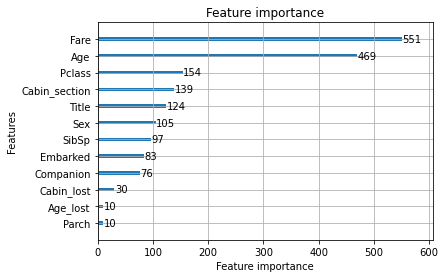

Fitting model 1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.187266	valid_1's binary_error: 0.187675
[100]	training's binary_error: 0.142322	valid_1's binary_error: 0.176471
Early stopping, best iteration is:
[81]	training's binary_error: 0.146067	valid_1's binary_error: 0.170868


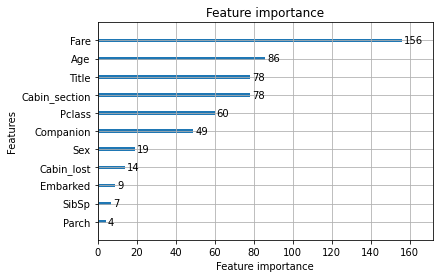

Fitting model 2
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.205993	valid_1's binary_error: 0.201681
[100]	training's binary_error: 0.155431	valid_1's binary_error: 0.165266
[150]	training's binary_error: 0.157303	valid_1's binary_error: 0.162465
Early stopping, best iteration is:
[127]	training's binary_error: 0.155431	valid_1's binary_error: 0.159664


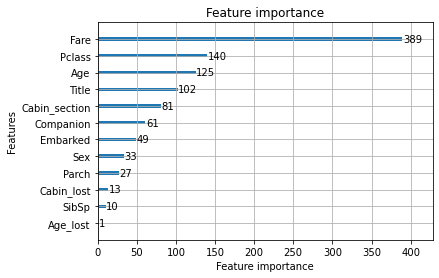

Fitting model 3
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.183521	valid_1's binary_error: 0.240896
[100]	training's binary_error: 0.129213	valid_1's binary_error: 0.212885
[150]	training's binary_error: 0.121723	valid_1's binary_error: 0.190476
[200]	training's binary_error: 0.121723	valid_1's binary_error: 0.182073
[250]	training's binary_error: 0.11985	valid_1's binary_error: 0.176471
[300]	training's binary_error: 0.114232	valid_1's binary_error: 0.173669
[350]	training's binary_error: 0.11236	valid_1's binary_error: 0.170868
[400]	training's binary_error: 0.110487	valid_1's binary_error: 0.168067
Early stopping, best iteration is:
[362]	training's binary_error: 0.11236	valid_1's binary_error: 0.168067


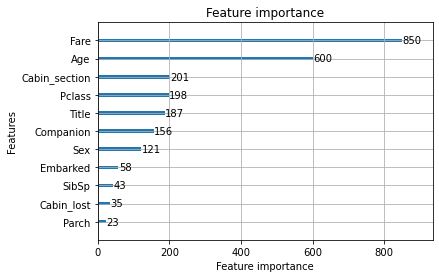

Fitting model 4
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.205993	valid_1's binary_error: 0.207283
[100]	training's binary_error: 0.155431	valid_1's binary_error: 0.201681
Early stopping, best iteration is:
[66]	training's binary_error: 0.157303	valid_1's binary_error: 0.19888


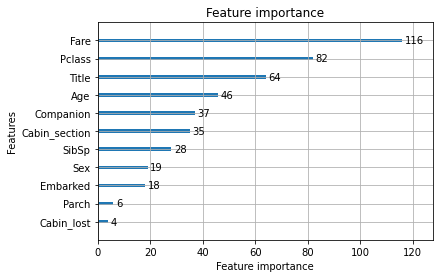

In [50]:
best_params = {k: grid.best_params_.get(k, v) for k, v in params.items()}
best_params['verbosity'] = -1
k = 5
valid_preds, train_preds, result = 0, 0, 0
for m in range(k):
    
    print('Fitting model', m)

        # Prepare the data set for fold
    train_split_df, valid_split_df = train_test_split(train, test_size=0.4)
    (train_lgb_dataset, train_labels,train_ids, train_split_df) = prepare_for_light_gbm(
            train_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
    (valid_lgb_dataset, valid_labels,valid_ids, valid_split_df) = prepare_for_light_gbm(
            valid_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
        # Train
    gbm = lgb.train(best_params, train_lgb_dataset, num_boost_round=100000,
                        valid_sets=[train_lgb_dataset, valid_lgb_dataset],
                        early_stopping_rounds=50, verbose_eval=50)

        # Plot importance
    lgb.plot_importance(gbm)
    plt.show()

        # Predict
    valid_preds += gbm.predict(valid_split_df, 
                                num_iteration=gbm.best_iteration) / k
    train_preds += gbm.predict(train_split_df, 
                                num_iteration=gbm.best_iteration) / k
    result += gbm.predict(test, num_iteration=gbm.best_iteration) / k 





In [51]:
result = np.int32(result > 0.5)
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('submission_re2.csv', index=False)


In [52]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# scaler = StandardScaler()
# y = df_train.Survived
# df_train = scaler.fit_transform(df_train.drop('Survived',axis=1))
# df_test = scaler.transform(df_test)
# X = df_train


In [53]:
train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_section,Cabin_lost,Age_lost,Title,Companion,Survived
0,0.242363,0,22.000000,1,0,7.2500,0.339009,0.299854,1,0,0.156673,0.259128,0
1,0.629630,1,38.000000,1,0,71.2833,0.553571,0.593220,0,0,0.795276,0.259128,1
2,0.242363,1,26.000000,0,0,7.9250,0.339009,0.299854,1,0,0.701087,-0.637826,1
3,0.629630,1,35.000000,1,0,53.1000,0.339009,0.593220,0,0,0.795276,0.259128,1
4,0.242363,0,35.000000,0,0,8.0500,0.339009,0.299854,1,0,0.156673,-0.637826,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.472826,0,27.000000,0,0,13.0000,0.339009,0.299854,1,0,0.002569,-0.637826,0
887,0.629630,1,19.000000,0,0,30.0000,0.339009,0.744681,0,0,0.701087,-0.637826,1
888,0.242363,1,6.461312,1,2,23.4500,0.339009,0.299854,1,1,0.701087,1.143377,0
889,0.629630,0,26.000000,0,0,30.0000,0.553571,0.593220,0,0,0.156673,-0.637826,1


----
## 2. 特征选择
### 前面的数据和模型经过验证，分数还不如之前。通过调整数据检验，发现是年龄的填补效果不好。重新处理数据，年龄改回中位数填补，对年龄和票钱分桶处理，构建新特征

In [64]:
from sklearn.preprocessing import LabelEncoder

In [65]:
df_train = pd.read_csv('train_processed.csv')
df_test = pd.read_csv('test_processed.csv')

In [66]:
df_train['Cabin_lost'] = train['Cabin_lost']
df_test['Cabin_lost'] = test['Cabin_lost']
df_train['Age_lost'] = train['Age_lost']
df_test['Age_lost'] = test['Age_lost']
df_train['Cabin_section'] = train['Cabin_section']
df_test['Cabin_section'] = test['Cabin_section']


In [67]:
df_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_lost,Age_lost,Cabin_section
0,1,0,3,male,22.0,1,0,21171,7.2500,S,1,0,0.299854
1,2,1,1,female,38.0,1,0,17599,71.2833,C,0,0,0.593220
2,3,1,3,female,26.0,0,0,3101282,7.9250,S,1,0,0.299854
3,4,1,1,female,35.0,1,0,113803,53.1000,S,0,0,0.593220
4,5,0,3,male,35.0,0,0,373450,8.0500,S,1,0,0.299854
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,211536,13.0000,S,1,0,0.299854
887,888,1,1,female,19.0,0,0,112053,30.0000,S,0,0,0.744681
888,889,0,3,female,27.0,1,2,6607,23.4500,S,1,1,0.299854
889,890,1,1,male,26.0,0,0,111369,30.0000,C,0,0,0.593220


In [68]:
train0 = pd.read_csv('train.csv')
test0 = pd.read_csv('test.csv')
name_train = train0.Name.values
name_test = test0.Name.values
title_list=set(['Mr.','Miss.','Mrs.','Miss.','Sir.', 'Lady.', 'Master.','Don.', 'Rev.', 'Dr.'])
def get_title(name):
    name=name.split(' ')
    join=set(name) & title_list
    if  join:
        return list(join)[0]
    else:
        return 'None'

title_train = [get_title(name) for name in name_train]
title_test = [get_title(name) for name in name_test]
df_train['Title'] = title_train
df_test['Title']= title_test

In [69]:

df_train["Companion"] = df_train["SibSp"] + df_train["Parch"]
df_test["Companion"] = df_test["SibSp"] +  df_test["Parch"]


In [60]:

# df_train["Fname"] = train0.Name.apply(lambda x: x.split(",")[0])
# df_test["Fname"] = test0.Name.apply(lambda x: x.split(",")[0])
# enc = TargetEncoder(cols='Fname').fit(df_train.drop('Survived',axis=1), df_train.Survived)
# df_train_X = enc.transform(df_train.drop('Survived',axis=1))
# df_train_y = df_train.Survived
# df_train = pd.concat([df_train_X, df_train_y], axis=1)
# df_test = enc.transform(df_test)


----
下面是借鉴了高分notebook的一个家庭成员或同行乘客生还情况的特征

In [70]:
train0['Last_Name'] = train0['Name'].apply(lambda x: str.split(x, ",")[0])
test0['Last_Name'] = test0['Name'].apply(lambda x: str.split(x, ",")[0])


DEFAULT_SURVIVAL_VALUE = 0.5
train0['Family_Survival'] = DEFAULT_SURVIVAL_VALUE
test0['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

data_df = pd.concat([train0, test0], axis=0)

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                        'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [71]:
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
df_train['Family_Survival'] = data_df['Family_Survival'][:891]
df_test['Family_Survival'] = data_df['Family_Survival'][891:]

Number of passenger with family/group survival information: 546


In [63]:
# df_train['Sex']=train0['Sex']
# df_train['Ticket']=train0['Ticket']
# dead_train = df_train[train0["Survived"] == 0]
# fname_ticket = dead_train[(dead_train["Sex"] == "female") & (dead_train["Companion"] >= 1)][["Fname", "Ticket"]]
# df_train["dead_family"] = np.where(df_train["Fname"].isin(fname_ticket["Fname"]) & train0["Ticket"].isin(fname_ticket["Ticket"]) & ((train0["Age"] >=1) | train0.Age.isnull()), 1, 0)
# df_test["dead_family"] = np.where(df_test["Fname"].isin(fname_ticket["Fname"]) & test0["Ticket"].isin(fname_ticket["Ticket"]) & ((test0["Age"] >=1) | test0.Age.isnull()), 1, 0)
# df_train.drop(['Fname'], axis=1, inplace=True)
# df_test.drop(['Fname'], axis=1,inplace=True)

In [84]:
df_train

,Survived,Pclass,Cabin_lost,Age_lost,Cabin_section,Companion,Family_Survival,is_adult,Sex_male,FareBin,AgeBin
0,0,3,1,0,0.299854,1,0.5,1,1,0.0,1.0
1,1,1,0,0,0.593220,1,0.5,1,0,4.0,2.0
2,1,3,1,0,0.299854,0,0.5,1,0,1.0,1.0
3,1,1,0,0,0.593220,1,0.0,1,0,4.0,2.0
4,0,3,1,0,0.299854,0,0.5,1,1,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0.299854,0,0.5,1,1,2.0,1.0
887,1,1,0,0,0.744681,0,0.5,1,0,3.0,1.0
888,0,3,1,1,0.299854,3,0.0,1,0,3.0,0.0
889,1,1,0,0,0.593220,0,0.5,1,1,3.0,1.0


In [73]:

df_train.drop('PassengerId', axis=1, inplace=True)
df_train.drop('Ticket', axis=1, inplace=True)
df_train.drop('SibSp', axis=1, inplace=True)
df_train.drop('Parch', axis=1, inplace=True)

df_test.drop('PassengerId', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)
df_test.drop('SibSp', axis=1, inplace=True)
df_test.drop('Parch', axis=1, inplace=True)


In [81]:
age_train = df_train.Age.values
age_test = df_test.Age.values

def is_adult(age):
    if  age>=18:
        return 1
    else:
        return 0
is_adult_train = [is_adult(age) for age in age_train]
is_adult_test = [is_adult(age) for age in age_test]
df_train['is_adult'] = is_adult_train
df_test['is_adult']= is_adult_test

In [79]:
df_train = pd.get_dummies(df_train, columns=["Sex"])
df_train.drop('Sex_female', axis=1, inplace=True)
df_test = pd.get_dummies(df_test, columns=["Sex"])
df_test.drop('Sex_female', axis=1, inplace=True)

In [77]:

le = LabelEncoder()
for feature in ['Embarked', 'Title','is_adult']:
    df_train[feature]=le.fit_transform(df_train[feature])
    df_test[feature]=le.transform(df_test[feature])


In [83]:
df_train.loc[train["Fare"] <= 7.854, "FareBin"] = 0
df_train.loc[(train["Fare"] > 7.854) & (df_train["Fare"] <= 10.5), "FareBin"] = 1
df_train.loc[(train["Fare"] > 10.5) & (df_train["Fare"] <= 21.558), "FareBin"] = 2
df_train.loc[(train["Fare"] > 21.558) & (df_train["Fare"] <= 41.579), "FareBin"] = 3
df_train.loc[train["Fare"] > 41.579, "FareBin"] = 4
df_test.loc[test["Fare"] <= 7.854, "FareBin"] = 0
df_test.loc[(test["Fare"] > 7.854) & (df_test["Fare"] <= 10.5), "FareBin"] = 1
df_test.loc[(test["Fare"] > 10.5) & (df_test["Fare"] <= 21.558), "FareBin"] = 2
df_test.loc[(test["Fare"] > 21.558) & (df_test["Fare"] <= 41.579), "FareBin"] = 3
df_test.loc[test["Fare"] > 41.579, "FareBin"] = 4
df_train.drop(['Fare'], axis=1, inplace=True)
df_test.drop(['Fare'], axis=1,inplace=True)

df_train.loc[train["Age"] <= 15, "AgeBin"] = 0
df_train.loc[(train["Age"] > 15) & (df_train["Age"] <= 30), "AgeBin"] = 1
df_train.loc[(train["Age"] > 30) & (df_train["Age"] <= 49), "AgeBin"] = 2
df_train.loc[(train["Age"] > 49) & (df_train["Age"] < 80), "AgeBin"] = 3
df_train.loc[train["Age"] >= 80, "AgeBin"] = 4
df_test.loc[test["Age"] <= 15, "AgeBin"] = 0
df_test.loc[(test["Age"] > 15) & (df_test["Age"] <= 30), "AgeBin"] = 1
df_test.loc[(test["Age"] > 30) & (df_test["Age"] <= 49), "AgeBin"] = 2
df_test.loc[(test["Age"] > 49) & (df_test["Age"] < 80), "AgeBin"] = 3
df_test.loc[test["Age"] >= 80, "AgeBin"] = 4
df_train.drop(['Age','is_adult','Title','Cabin_lost','Age_lost','Embarked'], axis=1, inplace=True)
df_test.drop(['Age','is_adult','Title','Cabin_lost', 'Age_lost','Embarked'], axis=1,inplace=True)
# df_train.drop(['Age','Title','Embarked'], axis=1, inplace=True)
# df_test.drop(['Age','Title', 'Embarked'], axis=1,inplace=True)

In [85]:
df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

In [70]:
def prepare_for_light_gbm(data,id_col,drop_cols,target_col):
    # Drop target column
    if target_col is not None:
        labels = data[target_col]
        drop_cols = drop_cols + [target_col]
    else:
        labels = []

    if id_col is not None:
        ids = data[id_col]
        drop_cols = drop_cols + [id_col]
    else:
        ids = []

    if drop_cols is not None:
        data = data.drop(drop_cols, axis=1)

    # Create LGB mats
    lgb_data = lgb.Dataset(data, label=labels, free_raw_data=False,
                           feature_name=list(data.columns), 
                           categorical_feature='auto')

    return lgb_data, labels, ids, data

train_split_df, valid_split_df = train_test_split(df_train, test_size=0.4)
columns_to_drop = ['Ticket', 'Cabin', 'Name']
(train_lgb_dataset, train_labels,
     train_ids, train_split_df) = prepare_for_light_gbm(
        train_split_df,drop_cols=[],id_col=None, target_col='Survived')

(valid_lgb_dataset, valid_labels,
     valid_ids, valid_split_df) = prepare_for_light_gbm(
        valid_split_df,drop_cols=[], id_col=None,target_col='Survived')

test_lgb_dataset, _, _, test_df = prepare_for_light_gbm(
        df_test,drop_cols=[],id_col=None, target_col=None)

    # Prepare data set using all the training data
(train_valid_lgb_dataset, train_valid_labels,
     _, train_valid_df) = prepare_for_light_gbm(
        df_train,drop_cols=[],id_col=None, target_col='Survived')

,'categorical_feature':[0,3,5,9]

In [71]:
params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
              'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
              'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
              'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
              'min_split_gain': 0.5, 'min_child_weight': 1, 
              'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
              'metric': 'binary_error','lambda_l2':0.1}
    # Create parameters to search
grid_params = {'learning_rate':[0.01], 'n_estimators': [8, 24, 48],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [42],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

    # Create classifier to use. Note that parameters have to be input manually
    # not as a dict!
mod = lgb.LGBMClassifier(**params)

    # To view the default model params:
mod.get_params().keys()

    # Create the grid
grid = GridSearchCV(mod, param_grid=grid_params, cv=5, verbose=1, n_jobs=-1)
    # Run the grid
grid.fit(train_valid_df, train_valid_labels)

    # Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'n_estimators': 48, 'num_leaves': 8, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 42, 'subsample': 0.7}
0.8148389931579938


In [ ]:
best_params 


Fitting model 0
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.187266	valid_1's binary_error: 0.187675
[100]	training's binary_error: 0.144195	valid_1's binary_error: 0.159664
Early stopping, best iteration is:
[75]	training's binary_error: 0.170412	valid_1's binary_error: 0.159664


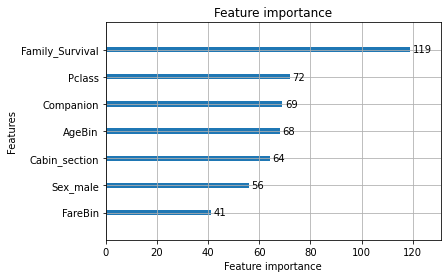

Fitting model 1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.183521	valid_1's binary_error: 0.193277
[100]	training's binary_error: 0.14794	valid_1's binary_error: 0.159664
Early stopping, best iteration is:
[97]	training's binary_error: 0.149813	valid_1's binary_error: 0.156863


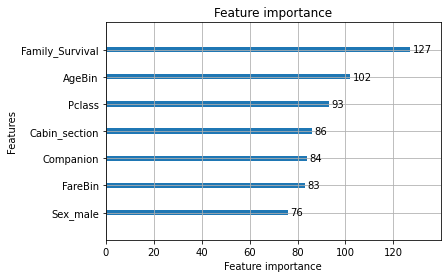

Fitting model 2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.202247	valid_1's binary_error: 0.179272
[100]	training's binary_error: 0.162921	valid_1's binary_error: 0.137255
[150]	training's binary_error: 0.159176	valid_1's binary_error: 0.114846
Early stopping, best iteration is:
[149]	training's binary_error: 0.159176	valid_1's binary_error: 0.114846


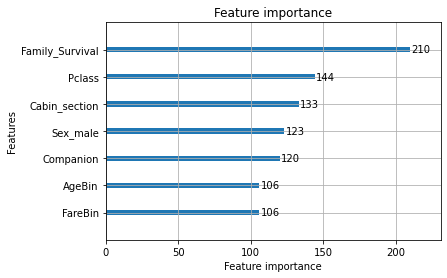

Fitting model 3
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.187266	valid_1's binary_error: 0.193277
[100]	training's binary_error: 0.14794	valid_1's binary_error: 0.148459
Early stopping, best iteration is:
[80]	training's binary_error: 0.14794	valid_1's binary_error: 0.148459


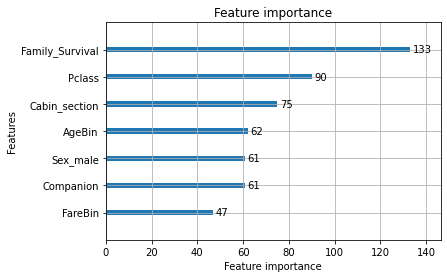

Fitting model 4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.172285	valid_1's binary_error: 0.182073
[100]	training's binary_error: 0.134831	valid_1's binary_error: 0.159664
Early stopping, best iteration is:
[80]	training's binary_error: 0.134831	valid_1's binary_error: 0.151261


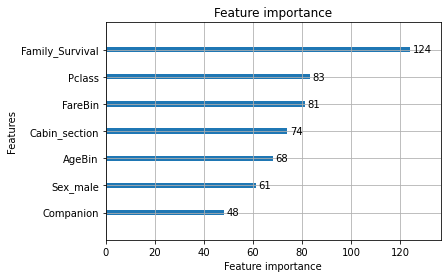

In [72]:
best_params = {k: grid.best_params_.get(k, v) for k, v in params.items()}
best_params['verbosity'] = -1
k = 5
valid_preds, train_preds, result = 0, 0, 0
for m in range(k):
    
    print('Fitting model', m)

        # Prepare the data set for fold
    train_split_df, valid_split_df = train_test_split(df_train, test_size=0.4)
    (train_lgb_dataset, train_labels,train_ids, train_split_df) = prepare_for_light_gbm(
            train_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
    (valid_lgb_dataset, valid_labels,valid_ids, valid_split_df) = prepare_for_light_gbm(
            valid_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
        # Train
    gbm = lgb.train(best_params, train_lgb_dataset, num_boost_round=100000,
                        valid_sets=[train_lgb_dataset, valid_lgb_dataset],
                        early_stopping_rounds=50, verbose_eval=50)

        # Plot importance
    lgb.plot_importance(gbm)
    plt.show()

        # Predict
    valid_preds += gbm.predict(valid_split_df, 
                                num_iteration=gbm.best_iteration) / k
    train_preds += gbm.predict(train_split_df, 
                                num_iteration=gbm.best_iteration) / k
    result += gbm.predict(df_test, num_iteration=gbm.best_iteration) / k 





In [73]:
result_write = np.int32(result > 0.5)
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result_write}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('submission_re13.csv', index=False)

----

相同数据集做逻辑回归

In [74]:

# train1=pd.read_csv('train_processed.csv')
# test1=pd.read_csv('test_processed.csv')



# pca=PCA(n_components=1)
# ncol=pca.fit_transform(train1[['SibSp','Parch']])
# train1["Companion"]=ncol
# pca=PCA(n_components=1)
# ncol=pca.fit_transform(test1[['SibSp','Parch']])
# test1["Companion"]=ncol
# df_train1 = pd.get_dummies(train1, columns=["Pclass","Embarked","Sex"])
# df_train1.drop('Sex_female', axis=1, inplace=True)
# df_train1.drop('PassengerId', axis=1, inplace=True)
# df_train1.drop('Ticket', axis=1, inplace=True)
# df_train1.drop('SibSp', axis=1, inplace=True)
# df_train1.drop('Parch', axis=1, inplace=True)
# df_test1 = pd.get_dummies(test1, columns=["Pclass","Embarked","Sex"])
# df_test1.drop('Sex_female', axis=1, inplace=True)
# df_test1.drop('PassengerId', axis=1, inplace=True)
# df_test1.drop('Ticket', axis=1, inplace=True)
# df_test1.drop('SibSp', axis=1, inplace=True)
# df_test1.drop('Parch', axis=1, inplace=True)
# picked_features = ['Age', 'Companion', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_male']



from sklearn.preprocessing import StandardScaler
# X1 = df_train[picked_features]
df_train1 = df_train.copy()
X1 = df_train.drop('Survived',axis=1).copy()
y = df_train.Survived.copy()
# df_test1=df_test1[picked_features]

# X1['Cabin_lost'] = train['Cabin_lost']
# df_test1['Cabin_lost'] = test['Cabin_lost']
# X1['Cabin_section'] = train['Cabin_section']
# df_test1['Cabin_section'] = test['Cabin_section']

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
df_test1 = scaler.transform(df_test)



from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X1, y)
result1=model.predict_proba(df_test1)[:,1]
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result1}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('prob_logistic.csv')


----

相同数据集做随机森林调参


In [75]:

# train3=pd.read_csv('train_processed.csv')
# test3=pd.read_csv('test_processed.csv')

# pca=PCA(n_components=1)
# ncol=pca.fit_transform(train3[['SibSp','Parch']])
# train3["Companion"]=ncol
# pca=PCA(n_components=1)
# ncol=pca.fit_transform(test3[['SibSp','Parch']])
# test3["Companion"]=ncol

# df_train = pd.get_dummies(train3, columns=["Pclass","Embarked","Sex"])
# df_train.drop('Sex_female', axis=1, inplace=True)
# df_train.drop('PassengerId', axis=1, inplace=True)
# df_train.drop('Ticket', axis=1, inplace=True)
# df_train.drop('SibSp', axis=1, inplace=True)
# df_train.drop('Parch', axis=1, inplace=True)

# df_test = pd.get_dummies(test3, columns=["Pclass","Embarked","Sex"])
# df_test.drop('Sex_female', axis=1, inplace=True)
# df_test.drop('PassengerId', axis=1, inplace=True)
# df_test.drop('Ticket', axis=1, inplace=True)
# df_test.drop('SibSp', axis=1, inplace=True)
# df_test.drop('Parch', axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# df_train['Cabin_lost'] = train['Cabin_lost']
# df_test['Cabin_lost'] = test['Cabin_lost']
# df_train['Cabin_section'] = train['Cabin_section']
# df_test['Cabin_section'] = test['Cabin_section']

scaler = StandardScaler()
X = scaler.fit_transform(df_train.drop('Survived',axis=1))
y = df_train.Survived
df_test1 = scaler.transform(df_test.copy())





In [76]:
estimator = RandomForestClassifier()
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params0 = {'n_estimators': range(1, 250 ,10)}

grid_search0 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params0, 
                        scoring='roc_auc')
grid_search0.fit(X,y)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': range(1, 250, 10)},
             return_train_score=True, scoring='roc_auc')

In [77]:
grid_search0.best_score_, grid_search0.best_params_

(0.8955667855494809, {'n_estimators': 151})

In [78]:
rf_clf0 = RandomForestClassifier(n_estimators=171, oob_score=True)
rf_clf0.fit(X,y).oob_score_

0.8316498316498316

In [79]:
estimator = RandomForestClassifier(n_estimators=171)
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params1 = {'max_depth':range(3,20,2),
        'min_samples_split':range(1,20,2),
        'min_samples_leaf':range(1,3)}

grid_search1 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params1, 
                        scoring='roc_auc')
grid_search1.fit(X,y)

D:\programs\envs\python36\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.87926397 0.87930674 0.8790709  0.87631732 0.87819421
 0.87840656 0.87346645 0.876687   0.87814288        nan 0.87688958
 0.87646541 0.87936884 0.87914836 0.87556638 0.87793948 0.87621967
 0.87812194 0.87900524        nan 0.8970284  0.89518308 0.89516366
 0.89506349 0.8954476  0.89576217 0.89325859 0.89173681 0.89138639
        nan 0.89470165 0.89511595 0.89618934 0.8953115  0.89520004
 0.89371705 0.89462125 0.89245935 0.89163754        nan 0.90343821
 0.90168633 0.90282633 0.9011077  0.8979506  0.89951102 0.89677248
 0.89823594 0.89640647        nan 0.90237382 0.89978136 0.89988003
 0.89919764 0.89826845 0.89773833 0.89589788 0.89763825 0.8961124
        nan 0.9023517  0.90417986 0.9039613  0.90402528 0.90154756
 0.90331095 0.90133274 0.90058563 0.89798381        nan 0.90490274
 0.90374846 0.90504472 0.90385356 0.90120962 0.900534

GridSearchCV(estimator=RandomForestClassifier(n_estimators=171), n_jobs=-1,
             param_grid={'max_depth': range(3, 20, 2),
                         'min_samples_leaf': range(1, 3),
                         'min_samples_split': range(1, 20, 2)},
             return_train_score=True, scoring='roc_auc')

In [80]:
grid_search1.best_score_, grid_search1.best_params_

(0.9087194962838454,
 {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 7})

In [81]:
rf_clf1 = RandomForestClassifier(n_estimators=171, oob_score=True,max_depth=15,min_samples_leaf=2, min_samples_split=7)
rf_clf1.fit(X,y).oob_score_

0.8383838383838383

In [82]:
estimator = RandomForestClassifier(n_estimators=171, oob_score=True,max_depth=15,min_samples_leaf=2, min_samples_split=7)
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params2 = {'max_features':['sqrt', 'log2', 'auto'],
        'criterion':['gini', 'entropy']}

grid_search2 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params2, 
                        scoring='roc_auc')
grid_search2.fit(X,y)
grid_search2.best_score_, grid_search2.best_params_

(0.9080458637383954, {'criterion': 'entropy', 'max_features': 'sqrt'})

In [83]:
rf_clf2 = RandomForestClassifier(n_estimators=121, oob_score=True,max_depth=9, min_samples_leaf=2, min_samples_split=5,
                                max_features='log2', criterion='gini')
rf_clf2.fit(X,y).oob_score_

0.8496071829405163

In [84]:
result2=rf_clf2.predict_proba(df_test1)[:,1]
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result2}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('prob_rf.csv')

----

三个模型尝试融合


In [85]:

lgbm_prob = result
logistic_prob = result1
rf_prob =result2


<AxesSubplot:>

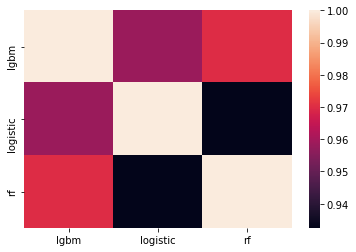

In [86]:
c_df = pd.DataFrame({'lgbm':result, 'logistic':result1, 'rf':rf_prob})
sns.heatmap(c_df.corr())

In [87]:
n_result = c_df.logistic + c_df.lgbm + c_df.rf
n_result = np.int32(n_result >= 1.5)
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':n_result}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('submission_re14.csv', index=False)